In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk import download
import re, string, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from sklearn.metrics import precision_recall_fscore_support
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'


Модель и токенизатор

In [16]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=20)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Подготовка данных

In [17]:
print("Загрузка датасета 20 Newsgroups...")
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = data.data[:500]  #  Ограничение до 500 строк
labels = data.target[:500]
label_names = data.target_names

download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

print("Предобработка текстов...")
texts_cleaned = [preprocess(doc) for doc in texts]


Загрузка датасета 20 Newsgroups...
Предобработка текстов...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirillzuenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создание датасета и токенизация

In [18]:
df = pd.DataFrame({'text': texts_cleaned, 'label': labels})

# Разделяем данные
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label'], random_state=42)

# Создаем datasets
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True)),
})

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)



Map: 100%|██████████| 75/75 [00:00<00:00, 6569.06 examples/s]


 Метрики и аргументы

In [19]:

# Определение обучающего и валидационного наборов данных
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

# Определение функции для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Получаем предсказания
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Определение аргументов для обучения
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=False,
)


Обучение и тест

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(tokenized_datasets["test"])
print("Test Accuracy:", test_results["eval_accuracy"])


/var/folders/48/zgpgn0m51jx3hpf6ntjx39l40000gn/T/ipykernel_1137/2808433093.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
44,2.989400
88,2.905600


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.18666666666666668


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📈 Визуализация точности

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Pyt

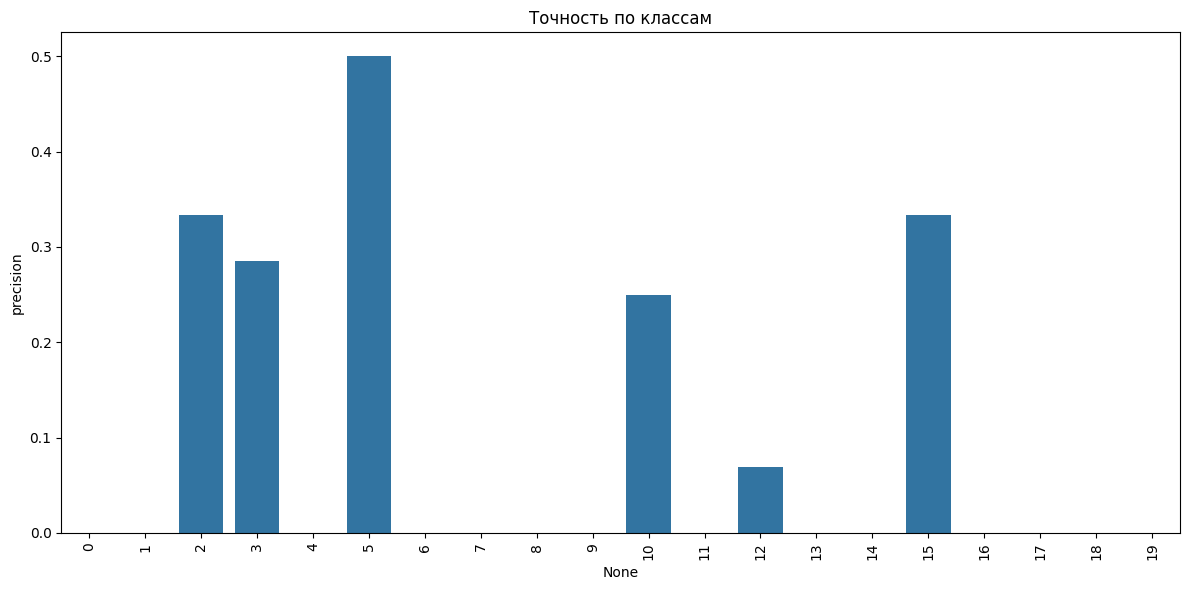

In [21]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
report = classification_report(true_labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_report.index[:-3], y=df_report["precision"][:-3])
plt.xticks(rotation=90)
plt.title("Точность по классам")
plt.tight_layout()
plt.show()
